In [1]:
import pandas as pd
import numpy as np
import quandl, math
import matplotlib.pyplot as plt
from matplotlib import style

style.use('ggplot')

#### The Dataset

In [2]:
# getting the dataset from quandl
df = quandl.get('WIKI/GOOGL')

# sneak peak of the dataset
df.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0


#### Feature Engineering

In [3]:
# selecting the initial features we need
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Volume']]

# generating new features from available ones
df['HL_PCT'] = ((df['Adj. High'] - df['Adj. Close'])/df['Adj. Close']) * 100.0
df['PCT_Change'] = ((df['Adj. Close'] - df['Adj. Open'])/df['Adj. Open']) * 100.0

# feature selection
df = df[['Adj. Close', 'HL_PCT', 'PCT_Change', 'Volume']]

# replacing missing features with outliers
df.fillna(-99999, inplace=True)

In [4]:
# we want to predict the Adj. Close price
forecast_col = "Adj. Close"
forecast_out = int(math.ceil(0.01*len(df)))
print("Number of days into the future to predict: ", forecast_out)

# label will now be the Adj. Close price shifted up by the number of days we want to predict
df['label'] = df[forecast_col].shift(-forecast_out)

Number of days into the future to predict:  35


In [5]:
df.head()

,Adj. Close,HL_PCT,PCT_Change,Volume,label
Date,,,,,
2004-08-19,50.322842,3.712563,0.324968,44659000.0,69.078238
2004-08-20,54.322689,0.710922,7.227007,22834300.0,67.839414
2004-08-23,54.869377,3.729433,-1.227880,18256100.0,68.912727
2004-08-24,52.597363,6.417469,-5.726357,15247300.0,70.668146
2004-08-25,53.164113,1.886792,1.183658,9188600.0,71.219849


#### Getting data ready for training and testing

In [6]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# getting all the features
X = np.array(df.drop(['label'], axis=1))

# normalizing the values of x
X = preprocessing.scale(X)

# the features to use to predict future prices, ones without labels
X_lately = X[-forecast_out:]

# the features to use to train the model, the ones with labels
X = X[:-forecast_out]

# removing rows without lables before getting the labels column
# making sure the number of features and labels match
df.dropna(inplace=True)
y = np.array(df['label'])


# getting the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### Model Training

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor

# getting some regressors for testing
linear_regression = LinearRegression()
decision_tree = DecisionTreeRegressor()
sv_regressor = SVR()
voting_regressor = VotingRegressor(estimators=[('linear_regression', linear_regression), ('decision_tree', decision_tree), ('sv_regressor', sv_regressor)])

models = [linear_regression, decision_tree, sv_regressor, voting_regressor]

best_model = None
best_score = 0

# training and getting the scores of all models
for model in models:
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    print(model.__class__.__name__, accuracy)
    # keepign track of the best model
    if accuracy > best_score:
        best_score = accuracy
        best_model = model

LinearRegression 0.9810613928371378
DecisionTreeRegressor 0.9734963051962102
SVR 0.766137291190569
VotingRegressor 0.958128642946841


In [8]:
forecast_set = None

if best_model:
    # retraining best model on the full dataset to improve performance
    best_model.fit(X, y)
    # using new model to predict the future prices
    forecast_set = best_model.predict(X_lately)
    print("Best Model Trained: ", best_model.__class__.__name__)

Best Model Trained:  LinearRegression


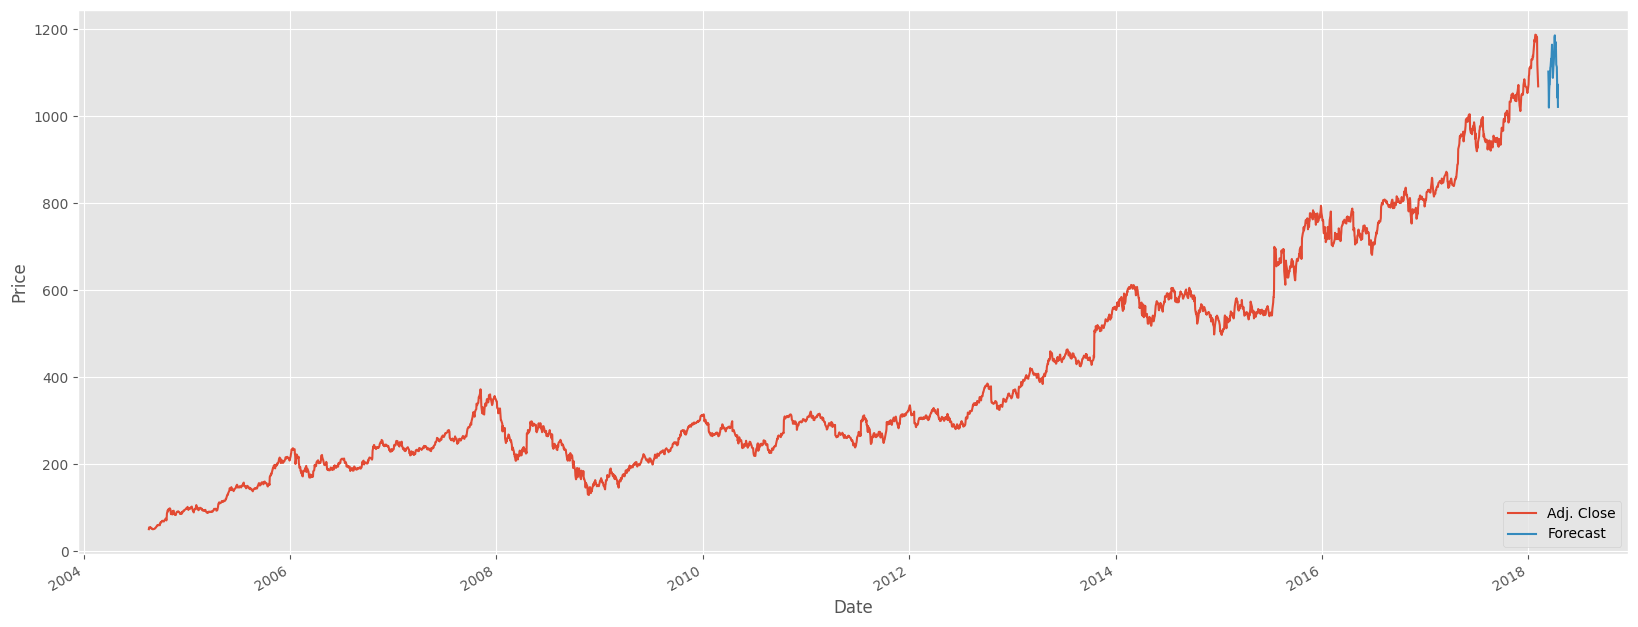

In [10]:
import datetime as dt

if forecast_set is not None:
    df['Forecast'] = np.nan

    # getting the last date in df
    last_date = df.iloc[-1].name
    last_unix = last_date.timestamp()
    one_day = 86400
    next_unix = last_unix + one_day

    for forecast in forecast_set:
        next_date = dt.datetime.fromtimestamp(next_unix)
        next_unix += one_day
        df.loc[next_date] = [np.nan for _ in range(len(df.columns) - 1)] + [forecast]

    # plotting the results
    df['Adj. Close'].plot()
    df['Forecast'].plot()
    plt.legend(loc=4)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.rcParams["figure.figsize"] = 20,8
    plt.show()